In [25]:
import torch
import numpy as np

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Generate random inputs
x_data = torch.tensor(10 * np.random.rand(1000, 1), dtype=torch.float32)
noise = torch.tensor(np.random.normal(0, 1, x_data.shape), dtype=torch.float32)

# Simulate outputs
y_data = 2 * x_data + noise

# Ensure y is within [0, 20]
y_data = torch.clamp(y_data, 0, 20)


In [26]:
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.relu(self.fc3(x))  # relu ensures output is non-negative

model = SimpleNN()
optimizer = optim.Adam(model.parameters())


In [27]:
criterion = nn.MSELoss()

def custom_loss(y_true, y_pred):
    mse = criterion(y_true, y_pred)
    penalty = torch.relu(y_pred - 20)  # penalty for exceeding 20
    return mse + 10 * penalty.sum()  # 10 is an arbitrary weight for the penalty

In [28]:
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(x_data)
    loss = custom_loss(y_data, outputs)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{50}, Loss: {loss.item()}")


Epoch 10/50, Loss: 117.5029067993164
Epoch 20/50, Loss: 114.6693115234375
Epoch 30/50, Loss: 111.56706237792969
Epoch 40/50, Loss: 108.13809204101562
Epoch 50/50, Loss: 104.36348724365234


In [29]:
model.eval()
with torch.no_grad():
    x_test = torch.tensor(10 * np.random.rand(100, 1), dtype=torch.float32)
    y_test = model(x_test)

    # Check if any predicted value exceeds 20
    print("Number of infeasible predictions:", (y_test > 20).sum().item())


Number of infeasible predictions: 0


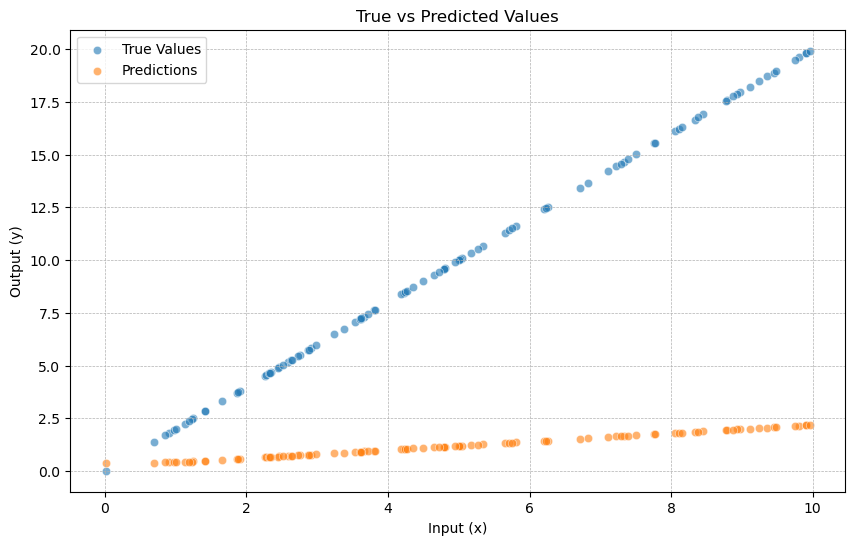

Mean Squared Error: 100.4318
R^2 Score: -2.2731


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Create true y values for the x_test data without adding the same noise tensor
y_true = 2 * x_test

# Predict using the trained model
model.eval()
with torch.no_grad():
    y_pred = model(x_test)

mse = ((y_pred - y_true) ** 2).mean().item()
ss_res = ((y_pred - y_true) ** 2).sum()
ss_tot = ((y_true - y_true.mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot
r2 = r2.item()

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(x_test.numpy(), y_true.numpy(), label="True Values", alpha=0.6, edgecolors='w', linewidth=0.5)
plt.scatter(x_test.numpy(), y_pred, label="Predictions", alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title("True vs Predicted Values")
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Print metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


In [31]:
parameters_dict = {}
for name, param in model.named_parameters():
    parameters_dict[name] = param.data.numpy()  # Convert tensor to numpy array
parameters_dict

{'fc1.weight': array([[-0.00748682],
        [ 0.5875743 ],
        [-0.82304513],
        [-0.735939  ],
        [-0.38515437],
        [ 0.21432695],
        [-0.05024094],
        [ 0.8391613 ],
        [-0.08874404],
        [ 0.31682625]], dtype=float32),
 'fc1.bias': array([-0.30221307, -0.14506586, -0.9553485 , -0.6622821 , -0.4122231 ,
        -0.01762498,  0.36315393,  0.64465404, -0.6779411 , -0.38302183],
       dtype=float32),
 'fc2.weight': array([[ 0.11485934,  0.26259175, -0.06507972,  0.23663697, -0.05097064,
          0.01067446,  0.25738043, -0.3218965 , -0.19907737, -0.08005787],
        [-0.12326556,  0.3267473 , -0.2049724 , -0.14557004, -0.2209295 ,
         -0.2445966 , -0.14178304,  0.32511288,  0.14110664,  0.20757398],
        [ 0.01663092, -0.18084157,  0.05350089, -0.2952602 , -0.22849551,
         -0.18175064,  0.17763211,  0.16635466, -0.14024544, -0.02969804],
        [ 0.20224687,  0.3143725 ,  0.12550515,  0.04272011,  0.21202639,
         -0.20302077, 